In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

import math
import matplotlib.pyplot as plt

import random
import numpy as np

In [2]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
torch.cuda.is_available()

True

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]) # better
# transform = transforms.Compose([transforms.ToTensor(),]) # worse

In [6]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

In [7]:
batch_size = 300
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True,
)

In [8]:
np.shape(next(iter(train_loader))[0])

torch.Size([300, 1, 28, 28])

torch.Size([300, 1, 28, 28])


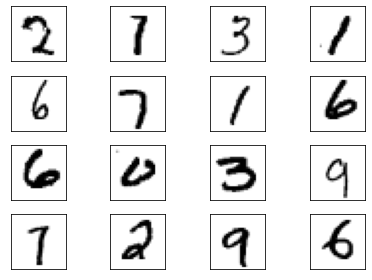

In [9]:
real_samples, mnist_labels = next(iter(train_loader))
print(real_samples.shape)
for i in range(16):
    ax = plt.subplot(4,4,i+1)
    # print(real_samples.min())
    # print(real_samples.max())
    # plt.imshow(real_samples[i].reshape(28,28),cmap="gray_r")
    plt.imshow(real_samples[i][0],cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [10]:
real_samples.view(real_samples.size(0), -1).shape

torch.Size([300, 784])

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28**2, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256,1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        output = self.model(x)
        return output
        
discriminator = Discriminator().to(device=device)

In [12]:
device

device(type='cuda')

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),

            nn.Linear(256, 512),
            nn.ReLU(),

            nn.Linear(512,1024),
            nn.ReLU(),

            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output
    
generator = Generator().to(device=device)

In [14]:
lr = 0.0001
num_epochs = 100
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [15]:
torch.randn(3,4)

tensor([[-1.2529, -1.1857,  1.6962,  0.1013],
        [ 0.2525, -0.4872,  0.9323,  1.5475],
        [ 0.0615, -0.0627, -0.5241,  0.7966]])

In [16]:
def plt_sampled_images(savefig="gan_test.png"):
    latent_space_samples = torch.randn(64, 100).to(device=device)
    generated_samples = generator(latent_space_samples)
    generated_samples = generated_samples.cpu().detach()
    generated_samples = generated_samples.reshape(8,8,1,28,28)
    
    fig, ax = plt.subplots(8,8, figsize=(8,8), dpi=200, constrained_layout=True)
    fig.suptitle(f"epoch {epoch:03d}/{num_epochs:03d}; step {step:03d}")
    for i in range(8):
        for j in range(8):
            # ax = plt.subplot(4,4,i+1)
            ax[i][j].imshow(np.transpose(generated_samples[i][j], axes=(1,2,0)), 
    cmap = 'gray')
            ax[i][j].axis('off')
            # ax[i][j].set_xticks([])
            # ax[i][j].set_yticks([])
    # plt.tight_layout()
    if savefig != False:
        plt.savefig(savefig)
        plt.close()

In [17]:
for epoch in range(num_epochs):
    for step, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for traing the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size,1)).to(device=device)
        
        latent_space_samples = torch.randn((batch_size,100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size,1)).to(device=device)

        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # data for training the generator
        latent_space_samples = torch.randn((batch_size,100)).to(device=device)

        # training the generator
        generator.zero_grad()
        output_generator = generator(latent_space_samples)
        output_discriminator = discriminator(output_generator)
        loss_generator = loss_function(output_discriminator, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # show less
        if epoch == 0 and step % 50 == 0:
            plt_sampled_images(f"gan_step{step:03d}.png")

    print(f"Epoch: {epoch}, step: {step}, Loss D.: {loss_discriminator}, Loss G.: {loss_generator}")
    plt_sampled_images(f"gan_epoch{epoch:03d}.png")

torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(),"discriminator.pth")

Epoch: 0, step: 199, Loss D.: 0.12969940900802612, Loss G.: 1.582436203956604
Epoch: 1, step: 199, Loss D.: 0.037851955741643906, Loss G.: 5.803991317749023
Epoch: 2, step: 199, Loss D.: 0.056502293795347214, Loss G.: 4.191160202026367
Epoch: 3, step: 199, Loss D.: 0.008199200965464115, Loss G.: 4.6465535163879395
Epoch: 4, step: 199, Loss D.: 0.009182248264551163, Loss G.: 8.058838844299316
Epoch: 5, step: 199, Loss D.: 0.006563619244843721, Loss G.: 6.981201171875
Epoch: 6, step: 199, Loss D.: 0.009447571821510792, Loss G.: 5.178860664367676
Epoch: 7, step: 199, Loss D.: 0.014732853509485722, Loss G.: 6.537977695465088
Epoch: 8, step: 199, Loss D.: 0.025064511224627495, Loss G.: 6.307345390319824
Epoch: 9, step: 199, Loss D.: 0.019697081297636032, Loss G.: 6.681049346923828
Epoch: 10, step: 199, Loss D.: 0.015647321939468384, Loss G.: 6.313117504119873
Epoch: 11, step: 199, Loss D.: 0.02448519691824913, Loss G.: 6.019388198852539
Epoch: 12, step: 199, Loss D.: 0.0034213524777442217, 

In [18]:
generator.state_dict()

OrderedDict([('model.0.weight',
              tensor([[ 0.0262, -0.0028, -0.0767,  ..., -0.0509,  0.0032, -0.0440],
                      [-0.0221,  0.0528, -0.0778,  ..., -0.0895, -0.0040, -0.0352],
                      [-0.0386, -0.0358,  0.0030,  ..., -0.0163,  0.0220, -0.0203],
                      ...,
                      [-0.0153,  0.0086, -0.0161,  ..., -0.0335, -0.0637,  0.0286],
                      [-0.0451, -0.0535, -0.0166,  ..., -0.0009,  0.0453, -0.0529],
                      [-0.0196, -0.0461, -0.0341,  ..., -0.0387,  0.0201, -0.0344]],
                     device='cuda:0')),
             ('model.0.bias',
              tensor([ 0.0404, -0.1383, -0.0011, -0.0986, -0.1314, -0.0953,  0.0012, -0.0022,
                      -0.0463, -0.0750,  0.0333, -0.1098,  0.0852, -0.0952,  0.0987,  0.0096,
                       0.0683, -0.0786, -0.0141,  0.0135, -0.0994, -0.0117,  0.0105,  0.0449,
                      -0.0482, -0.0429, -0.0349, -0.0195, -0.0012, -0.1017,  0.0010,

In [ ]:
generator_loaded = Generator().to(device=device)
discriminator_loaded = Discriminator().to(device=device)

generator_loaded.load_state_dict(torch.load("generator.pth"))
discriminator_loaded.load_state_dict(torch.load("discriminator.pth"))

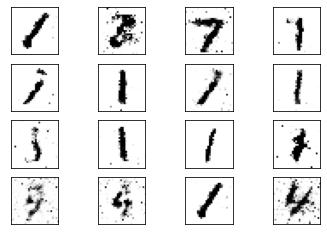

In [19]:
generated_loaded_samples = generator_loaded(latent_space_samples)
generated_loaded_samples = generated_loaded_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(generated_loaded_samples[i].reshape(28,28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [21]:
sum(p.numel() for p in generator.parameters())

1486352

In [22]:
sum(p.numel() for p in discriminator.parameters())

1460225